## Term project: CNN to classify IC package types

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import time
import glob

from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

In [14]:
# For reproducible results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [15]:
# try cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
# Data augmentation and normalization for training
# expand smaller images to 128x128
# crop random 128x128 patches from larger images
# convert to grayscale
# sharpen images

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]),
}

In [17]:
# data is stored as: chip-dip, chip-ga, chip-qfp, ... class dirs in the root dataset directory
# pick random 150 images from each class for training and 25 for testing
data_dir = 'dataset'
classes = os.listdir(data_dir)

# load data
train_data = []
test_data = []

for c in classes:
    files = glob.glob(os.path.join(data_dir, c, '*.jpg'))
    files.extend(glob.glob(os.path.join(data_dir, c, '*.png')))
    files.extend(glob.glob(os.path.join(data_dir, c, '*.jpeg')))
    random.shuffle(files)
    train_data += [(f, c) for f in files[:150]]
    test_data += [(f, c) for f in files[150:180]]

random.shuffle(train_data)
random.shuffle(test_data)

In [18]:
# define dataset class
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path)
        if self.transform:
            img = transforms.functional.to_grayscale(img, num_output_channels=3)
            img = transforms.functional.adjust_contrast(img, 2)
            img = transforms.functional.adjust_sharpness(img, 2)
            img = self.transform(img)
        return img, classes.index(label)
    
datasets = {x: ImageDataset(data, data_transforms[x]) for x, data in [('train', train_data), ('val', test_data)]}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=8, shuffle=True, num_workers=0) for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes

print('Train size:', dataset_sizes['train'])
print('Validation size:', dataset_sizes['val'])
print('Classes:', class_names)

Train size: 600
Validation size: 105
Classes: ['chip-dip', 'chip-qfp', 'chip-soic', 'chip-sop']


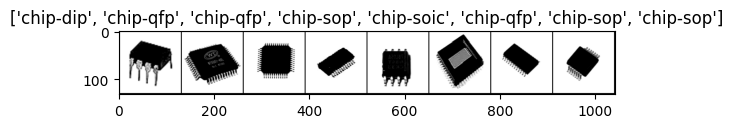

In [19]:
# show some images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, temp = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in temp])


In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    model_performance = {
        'lr': [],
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model_performance['lr'].append(optimizer.param_groups[0]['lr'])

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            
            if phase == 'train':
                model_performance['train_loss'].append(epoch_loss)
                model_performance['train_acc'].append(epoch_acc)
            else:
                model_performance['val_loss'].append(epoch_loss)
                model_performance['val_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, model_performance

In [21]:
model_ff = models.resnet18(pretrained=True)
# for param in model_ff.parameters():
#     param.requires_grad = False
num_ftrs_ff = model_ff.fc.in_features
model_ff.fc = nn.Linear(num_ftrs_ff, len(class_names))
model_ff = model_ff.to(device)

c:\Users\localuser-1\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\localuser-1\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ff.parameters(), lr=0.001, momentum=0.9, weight_decay=0.05)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ff, model_ff_performance = train_model(model_ff, criterion, optimizer, exp_lr_scheduler, num_epochs=30) #no acc gains after 30
torch.save(model_ff.state_dict(), 'resnet.pth')

Epoch 0/29
----------


100%|██████████| 75/75 [00:13<00:00,  5.48it/s]


train Loss: 0.9310 Acc: 0.6117


100%|██████████| 14/14 [00:01<00:00, 12.04it/s]


val Loss: 0.5305 Acc: 0.8286

Epoch 1/29
----------


100%|██████████| 75/75 [00:06<00:00, 12.17it/s]


train Loss: 0.5038 Acc: 0.8100


100%|██████████| 14/14 [00:00<00:00, 15.37it/s]


val Loss: 0.3419 Acc: 0.8952

Epoch 2/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.68it/s]


train Loss: 0.3946 Acc: 0.8633


100%|██████████| 14/14 [00:00<00:00, 14.04it/s]


val Loss: 0.2933 Acc: 0.8762

Epoch 3/29
----------


100%|██████████| 75/75 [00:06<00:00, 12.01it/s]


train Loss: 0.3952 Acc: 0.8733


100%|██████████| 14/14 [00:00<00:00, 14.14it/s]


val Loss: 0.4454 Acc: 0.8286

Epoch 4/29
----------


100%|██████████| 75/75 [00:07<00:00,  9.98it/s]


train Loss: 0.3354 Acc: 0.8833


100%|██████████| 14/14 [00:01<00:00, 13.25it/s]


val Loss: 0.3881 Acc: 0.8667

Epoch 5/29
----------


100%|██████████| 75/75 [00:06<00:00, 10.79it/s]


train Loss: 0.2240 Acc: 0.9250


100%|██████████| 14/14 [00:01<00:00, 13.60it/s]


val Loss: 0.2641 Acc: 0.9238

Epoch 6/29
----------


100%|██████████| 75/75 [00:06<00:00, 10.80it/s]


train Loss: 0.2237 Acc: 0.9333


100%|██████████| 14/14 [00:00<00:00, 14.31it/s]


val Loss: 0.2977 Acc: 0.9143

Epoch 7/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.42it/s]


train Loss: 0.2155 Acc: 0.9133


100%|██████████| 14/14 [00:00<00:00, 15.40it/s]


val Loss: 0.3355 Acc: 0.8857

Epoch 8/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.42it/s]


train Loss: 0.2270 Acc: 0.9183


100%|██████████| 14/14 [00:01<00:00, 13.31it/s]


val Loss: 0.2298 Acc: 0.9333

Epoch 9/29
----------


100%|██████████| 75/75 [00:07<00:00, 10.39it/s]


train Loss: 0.1741 Acc: 0.9383


100%|██████████| 14/14 [00:01<00:00, 12.76it/s]


val Loss: 0.2520 Acc: 0.9048

Epoch 10/29
----------


100%|██████████| 75/75 [00:07<00:00, 10.49it/s]


train Loss: 0.1484 Acc: 0.9533


100%|██████████| 14/14 [00:01<00:00, 13.97it/s]


val Loss: 0.1703 Acc: 0.9619

Epoch 11/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.12it/s]


train Loss: 0.0905 Acc: 0.9717


100%|██████████| 14/14 [00:00<00:00, 14.78it/s]


val Loss: 0.1806 Acc: 0.9619

Epoch 12/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.62it/s]


train Loss: 0.0989 Acc: 0.9733


100%|██████████| 14/14 [00:00<00:00, 14.31it/s]


val Loss: 0.1949 Acc: 0.9429

Epoch 13/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.72it/s]


train Loss: 0.1077 Acc: 0.9683


100%|██████████| 14/14 [00:00<00:00, 15.18it/s]


val Loss: 0.1916 Acc: 0.9429

Epoch 14/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.71it/s]


train Loss: 0.0884 Acc: 0.9733


100%|██████████| 14/14 [00:00<00:00, 15.09it/s]


val Loss: 0.2132 Acc: 0.9238

Epoch 15/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.86it/s]


train Loss: 0.0921 Acc: 0.9800


100%|██████████| 14/14 [00:00<00:00, 15.10it/s]


val Loss: 0.1913 Acc: 0.9524

Epoch 16/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.91it/s]


train Loss: 0.0740 Acc: 0.9850


100%|██████████| 14/14 [00:00<00:00, 15.21it/s]


val Loss: 0.1848 Acc: 0.9524

Epoch 17/29
----------


100%|██████████| 75/75 [00:06<00:00, 12.06it/s]


train Loss: 0.0827 Acc: 0.9783


100%|██████████| 14/14 [00:00<00:00, 14.95it/s]


val Loss: 0.1848 Acc: 0.9333

Epoch 18/29
----------


100%|██████████| 75/75 [00:06<00:00, 12.15it/s]


train Loss: 0.0864 Acc: 0.9767


100%|██████████| 14/14 [00:00<00:00, 14.31it/s]


val Loss: 0.1856 Acc: 0.9429

Epoch 19/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.98it/s]


train Loss: 0.0671 Acc: 0.9817


100%|██████████| 14/14 [00:00<00:00, 15.44it/s]


val Loss: 0.1786 Acc: 0.9429

Epoch 20/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.74it/s]


train Loss: 0.0764 Acc: 0.9817


100%|██████████| 14/14 [00:00<00:00, 15.02it/s]


val Loss: 0.2033 Acc: 0.9238

Epoch 21/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.90it/s]


train Loss: 0.0776 Acc: 0.9900


100%|██████████| 14/14 [00:00<00:00, 14.65it/s]


val Loss: 0.1796 Acc: 0.9619

Epoch 22/29
----------


100%|██████████| 75/75 [00:06<00:00, 12.06it/s]


train Loss: 0.0517 Acc: 0.9917


100%|██████████| 14/14 [00:00<00:00, 14.69it/s]


val Loss: 0.2012 Acc: 0.9333

Epoch 23/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.83it/s]


train Loss: 0.0594 Acc: 0.9883


100%|██████████| 14/14 [00:00<00:00, 14.74it/s]


val Loss: 0.1872 Acc: 0.9429

Epoch 24/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.78it/s]


train Loss: 0.0661 Acc: 0.9883


100%|██████████| 14/14 [00:00<00:00, 14.67it/s]


val Loss: 0.1646 Acc: 0.9619

Epoch 25/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.91it/s]


train Loss: 0.0539 Acc: 0.9917


100%|██████████| 14/14 [00:00<00:00, 14.22it/s]


val Loss: 0.2043 Acc: 0.9238

Epoch 26/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.66it/s]


train Loss: 0.0739 Acc: 0.9783


100%|██████████| 14/14 [00:00<00:00, 14.79it/s]


val Loss: 0.2069 Acc: 0.9333

Epoch 27/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.72it/s]


train Loss: 0.0573 Acc: 0.9883


100%|██████████| 14/14 [00:00<00:00, 15.09it/s]


val Loss: 0.1950 Acc: 0.9238

Epoch 28/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.85it/s]


train Loss: 0.0834 Acc: 0.9783


100%|██████████| 14/14 [00:00<00:00, 15.44it/s]


val Loss: 0.1857 Acc: 0.9524

Epoch 29/29
----------


100%|██████████| 75/75 [00:06<00:00, 11.90it/s]


train Loss: 0.0601 Acc: 0.9883


100%|██████████| 14/14 [00:00<00:00, 14.56it/s]

val Loss: 0.1951 Acc: 0.9429

Training complete in 3m 51s
Best val Acc: 0.961905


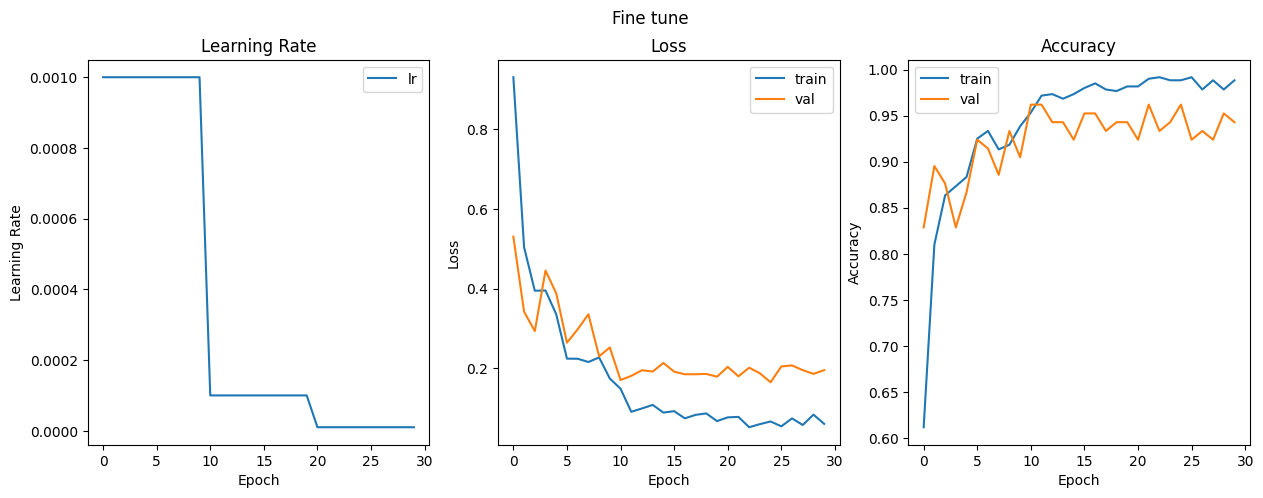

In [23]:
def plot_result(model, title):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Learning Rate")
    plt.plot(model['lr'], label='lr')
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.title("Loss")
    plt.plot(model['train_loss'], label='train')
    plt.plot(model['val_loss'], label='val')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.title("Accuracy")
    model['train_acc'] = [x.cpu() for x in model['train_acc']]
    model['val_acc'] = [x.cpu() for x in model['val_acc']]
    plt.plot(model['train_acc'], label='train')
    plt.plot(model['val_acc'], label='val')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.suptitle(title)
    plt.show()

plot_result(model_ff_performance, "Fine tune")

accuracy: 0.9429
recall: [0.9        1.         0.96666667 0.93333333]
precision: [1.         0.9375     0.90625    0.93333333]
f1: [0.94736842 0.96774194 0.93548387 0.93333333]


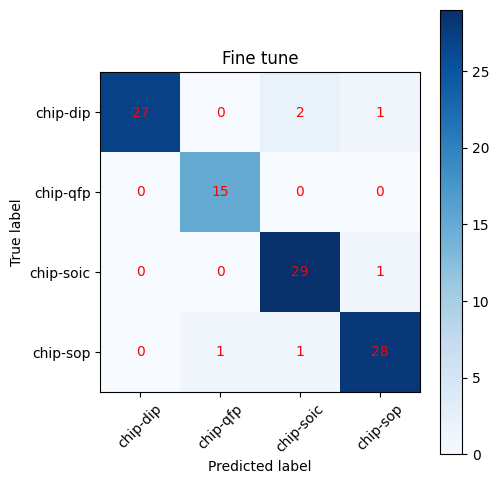

In [28]:
from sklearn.metrics import confusion_matrix

def test_model(model, model_name):
    model.load_state_dict(torch.load(model_name))
    model.eval()

    running_corrects = 0
    y_true = []
    y_pred = []

    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    accuracy = running_corrects.double() / dataset_sizes['val']
    recall = np.diag(confusion_matrix(y_true, y_pred)) / np.sum(confusion_matrix(y_true, y_pred), axis=1)
    precision = np.diag(confusion_matrix(y_true, y_pred)) / np.sum(confusion_matrix(y_true, y_pred), axis=0)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, y_true, y_pred, recall, precision, f1

accuracy_ff, y_true_ff, y_pred_ff, recall_ff, precision_ff, f1_ff = test_model(model_ff, 'resnet.pth')

print(f"accuracy: {accuracy_ff:.4f}")
print(f"recall: {recall_ff}")
print(f"precision: {precision_ff}")
print(f"f1: {f1_ff}")

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='red')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(y_true_ff, y_pred_ff, "Fine tune")

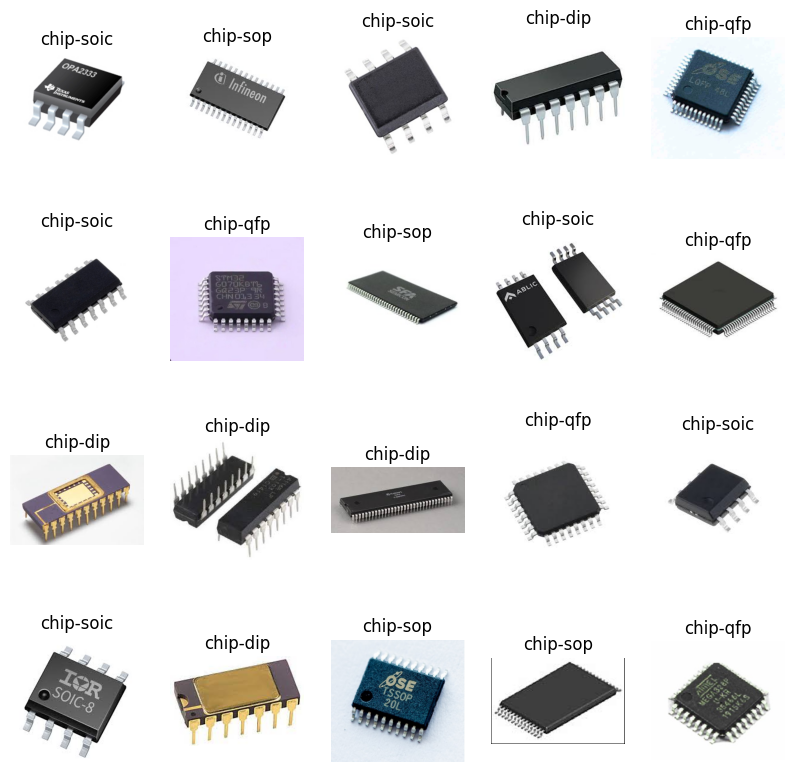

In [27]:
model_ff.load_state_dict(torch.load('resnet.pth'))
model_ff.eval()

predict_dir = 'test_dataset'
predict_files = glob.glob(os.path.join(predict_dir, '*.jpg'))
predict_files.extend(glob.glob(os.path.join(predict_dir, '*.png')))
predict_files.extend(glob.glob(os.path.join(predict_dir, '*.jpeg')))

random.shuffle(predict_files)

fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 4

# load and transform images
for i, f in enumerate(predict_files[:columns*rows]):
    img = Image.open(f)
    img = transforms.functional.to_grayscale(img, num_output_channels=3)
    img = transforms.functional.adjust_contrast(img, 2)
    img = transforms.functional.adjust_sharpness(img, 2)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        output = model_ff(img)
        _, pred = torch.max(output, 1)
        pred = pred.cpu().numpy()[0]
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(Image.open(f))
        ax.set_title(class_names[pred])
        ax.axis('off')

plt.show()